In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from data_provider.coinmarketcap import CoinMarketCapAPI, get_cmc_listing_info_latest
import pandas as pd
from datetime import datetime, timedelta
import time
from datetime import timezone
import ccxt
from pathlib import Path
import json
from data_provider.market_data_provider import get_ccxt_ohlcv, get_freqtrade_ohlcv

import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import randint as sp_randint

from sklearn.decomposition import PCA


SANDBOX_API_KEY = 'ecef1c0b-5806-45ba-9d4e-9cb94a5e67b4'
cmc = CoinMarketCapAPI(SANDBOX_API_KEY)
cryptocurrency_listings_df, cmc_id_mapping = get_cmc_listing_info_latest()

In [3]:
shit_coin_info_df = cryptocurrency_listings_df[~cryptocurrency_listings_df['is_stable_coin']].copy()
shit_coin_info_df = shit_coin_info_df[~shit_coin_info_df['is_wrapped_token']].copy()
#shit_coin_info_df['market_cap_rank'] = shit_coin_info_df['market_cap'].rank(ascending=False)

In [4]:
top_200_total_market_value = shit_coin_info_df['market_cap'].sum() # 1.65 trillion
total_market_value_ratio_cumsum = shit_coin_info_df['market_cap'].cumsum() / top_200_total_market_value
shit_coin_info_df['total_market_value_ratio_cumsum'] = total_market_value_ratio_cumsum

In [5]:
#top 50 is 0.940182% mc
#shit_coin_info_df.plot.line(x='market_cap_rank', y='total_market_value_ratio_cumsum')
top_50_shit_coins_info_df = shit_coin_info_df[shit_coin_info_df['market_cap_rank']<=50]
top_50_shit_coins_ticker = top_50_shit_coins_info_df['symbol'].values.tolist()
top_50_shit_coins_symbol = [f"{t}/USDT" for t in top_50_shit_coins_ticker]

In [6]:
binance_exchange = ccxt.binance()
binance_markets = binance_exchange.load_markets()
ftx_exchange = ccxt.ftx()
ftx_markets = ftx_exchange.load_markets()

binance_top_50symbols = list(set(top_50_shit_coins_symbol) & set(binance_exchange.symbols))
rest_list = list(set(top_50_shit_coins_symbol) - set(binance_top_50symbols)) # 
ftx_top_50symbols = ['CRO/USD']

rolling autocorrelation on the 1W time frame shows interesting
tendency to be strongly positive on all markets.

We found statistically significant autocorrelation of lower orders for all considered markets on 5m
and 1H time frames by calculating Pearson’s autocorrelation coefficient. The same observation was confirmed
by Ljung-Box test.

However, rolling
autocorrelation might constitute a useful feature to improve the predictive power of machine learning models.

In [34]:
top_50_ohlcv_df = get_freqtrade_ohlcv(binance_top_50symbols, 'binance', '1h')

In [ ]:
shit_coin_info_df_rolling_sample = shit_coin_info_df.loc[(shit_coin_info_df.index.get_level_values('date') > timewinodw_start)]

In [8]:
timewinodw_start = datetime.today() - timedelta(days=120)
top_50_ohlcv_rolling_sample_df = top_50_ohlcv_df.loc[(top_50_ohlcv_df.index.get_level_values('date') > timewinodw_start)]

price_panel_data = top_50_ohlcv_rolling_sample_df['close'].unstack().T.copy()
return_panel_data = price_panel_data.pct_change(1)
return_panel_data = return_panel_data.dropna(how='all')
# drop new ticker, since its impact should be small now

pca_return_panel_data = return_panel_data.dropna(how='any', axis=1)

pca_return_panel_data_normalized_df = (pca_return_panel_data - pca_return_panel_data.mean()) / pca_return_panel_data.std()

pca_return_panel_data_normalized_df
symbols = pca_return_panel_data_normalized_df.columns.values
n_symbols = len(symbols)

In [9]:
pca = PCA(n_components=pca_return_panel_data_normalized_df.shape[1])
pca.fit(pca_return_panel_data_normalized_df)

PCA(n_components=41)

29 principal components explain 95.00% of variance


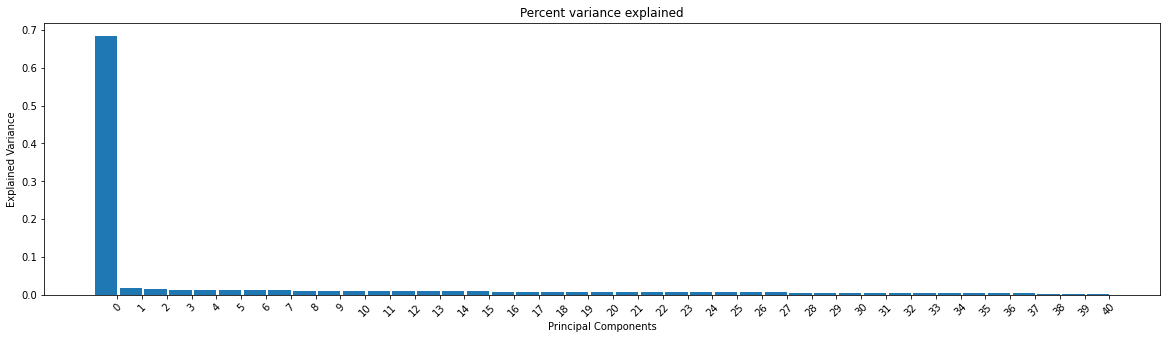

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
def plotPCA(pca, plot=False):

    # Visualizing Variance against number of principal components.
    #cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != 'DJIA'].cov()

    var_threshold = 0.95
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = pca.explained_variance_ratio_.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(pca, plot=True)

In [11]:
pc_components = pd.DataFrame(pca.components_ )
pc_components.columns = pca.feature_names_in_
pc_component_ptf_weights_normalized = pc_components / pca_return_panel_data.std()

In [15]:
pc_component_ptf_weights_normalized.columns

Index(['AAVE/USDT', 'ADA/USDT', 'ALGO/USDT', 'ATOM/USDT', 'AVAX/USDT',
       'AXS/USDT', 'BCH/USDT', 'BNB/USDT', 'BTC/USDT', 'CAKE/USDT',
       'DOGE/USDT', 'DOT/USDT', 'EGLD/USDT', 'EOS/USDT', 'ETC/USDT',
       'ETH/USDT', 'FIL/USDT', 'FTM/USDT', 'FTT/USDT', 'HBAR/USDT', 'ICP/USDT',
       'KLAY/USDT', 'LINK/USDT', 'LTC/USDT', 'LUNA/USDT', 'MANA/USDT',
       'MATIC/USDT', 'NEAR/USDT', 'RUNE/USDT', 'SAND/USDT', 'SHIB/USDT',
       'SOL/USDT', 'THETA/USDT', 'TRX/USDT', 'UNI/USDT', 'VET/USDT',
       'XLM/USDT', 'XMR/USDT', 'XRP/USDT', 'XTZ/USDT', 'ZEC/USDT'],
      dtype='object')

In [18]:
def plotEigen(weights, plot=False):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()}, index = pc_component_ptf_weights_normalized.columns) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(pc_component_ptf_weights_normalized.columns),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

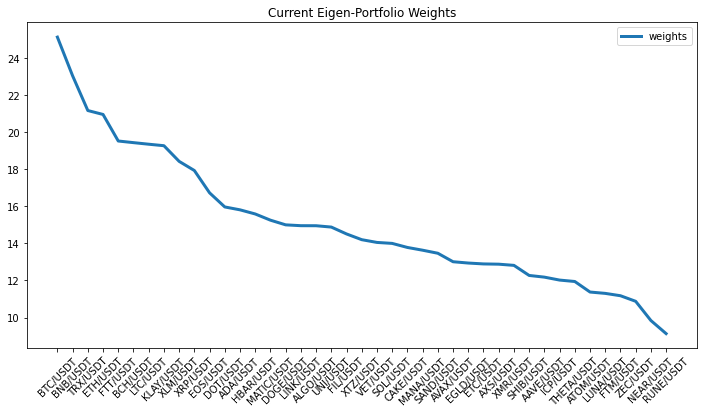

In [19]:
eigen_ptf1_weight = plotEigen(weights=pc_component_ptf_weights_normalized.loc[0]*-1, plot=True)

In [20]:
def get_coresponding_market_info(x, info, coin_info_df):
    cmc_id = cmc_id_mapping[x.name[:x.name.find('/')]]
    return coin_info_df.loc[cmc_id][info]
    

In [21]:
eigen_ptf1_weight['market_cap']= eigen_ptf1_weight.apply(lambda x: get_coresponding_market_info(x, 'market_cap', shit_coin_info_df), axis=1)

eigen_ptf1_weight['weights_rank'] = eigen_ptf1_weight['weights'].rank(ascending=False)
eigen_ptf1_weight['market_cap_rank'] = eigen_ptf1_weight['market_cap'].rank(ascending=False)

eigen_ptf1_weight['vol'] = pca_return_panel_data.std()
#eigen_ptf2_weight = plotEigen(weights=pc_component_ptf_weights_normalized.loc[1]*-1, plot=True)
#eigen_ptf3_weight = plotEigen(weights=pc_component_ptf_weights_normalized.loc[2]*-1, plot=True)
#eigen_ptf4_weight = plotEigen(weights=pc_component_ptf_weights_normalized.loc[3]*-1, plot=True)

In [22]:
def eigenreturn_compare(pca_return_panel_data, eigen_ptf_weight, vs_symbol='BTC/USDT', inverse_invest=False):
    direaction = -1 if inverse_invest else 1
    eigen_portfolio_returns = np.dot(pca_return_panel_data.loc[:, eigen_ptf_weight.index], direaction * eigen_ptf_weight['weights']/eigen_ptf_weight['weights'].sum())
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=pca_return_panel_data.index)

    return_compare_plot = pd.DataFrame({'PC': eigen_portfolio_returns, vs_symbol: pca_return_panel_data.loc[:, vs_symbol]}, index=pca_return_panel_data.index)

    np.cumprod(return_compare_plot + 1).plot(title=f'Returns of {vs_symbol} vs. PC eigen-portfolio', 
                                 figsize=(12,6), linewidth=3)
    
    return eigen_portfolio_returns
    plt.show()

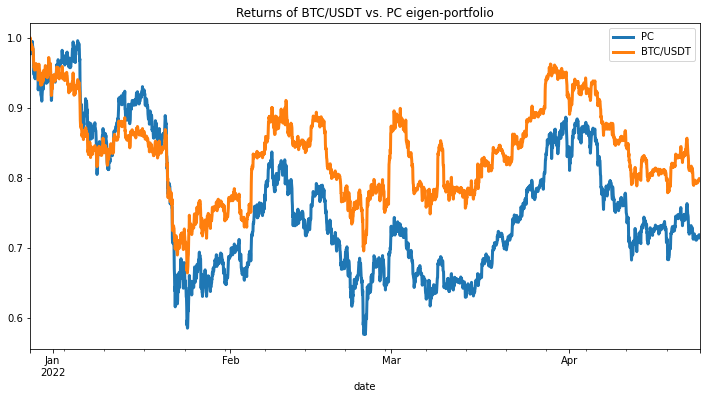

In [23]:
eigen_portfolio_returns = eigenreturn_compare(pca_return_panel_data, eigen_ptf1_weight, vs_symbol='BTC/USDT', inverse_invest=False)

In [24]:
eigen_portfolio_returns = np.dot(pca_return_panel_data.loc[:, eigen_ptf1_weight.index], 1 * eigen_ptf1_weight['weights']/eigen_ptf1_weight['weights'].sum())
eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=pca_return_panel_data.index)

In [25]:
eigen_portfolio_returns

date
2021-12-28 02:00:00   -0.003847
2021-12-28 03:00:00   -0.005108
2021-12-28 04:00:00   -0.013961
2021-12-28 05:00:00    0.008086
2021-12-28 06:00:00    0.000864
                         ...   
2022-04-23 14:00:00   -0.000140
2022-04-23 15:00:00    0.001018
2022-04-23 16:00:00    0.001474
2022-04-23 17:00:00   -0.000187
2022-04-23 18:00:00   -0.006172
Length: 2801, dtype: float64

In [26]:
from scipy.stats import linregress

In [31]:
pca_return_panel_data

pair,AAVE/USDT,ADA/USDT,ALGO/USDT,ATOM/USDT,AVAX/USDT,AXS/USDT,BCH/USDT,BNB/USDT,BTC/USDT,CAKE/USDT,...,SOL/USDT,THETA/USDT,TRX/USDT,UNI/USDT,VET/USDT,XLM/USDT,XMR/USDT,XRP/USDT,XTZ/USDT,ZEC/USDT
date,,,,,,,,,,,,,,,,,,,,,
2021-12-28 02:00:00,-0.022511,0.004035,-0.012644,-0.012268,-0.005383,-0.004483,-0.004135,0.000181,-0.000870,0.001567,...,-0.005849,-0.003936,-0.004635,-0.006694,-0.002934,-0.008618,0.006013,-0.002550,0.007382,-0.005903
2021-12-28 03:00:00,-0.018712,-0.004689,-0.004080,0.000710,0.002706,-0.003162,-0.005026,-0.001085,0.001060,-0.005477,...,-0.000420,0.004327,-0.006292,-0.030067,-0.003678,-0.004868,-0.005517,-0.005557,-0.013637,-0.036817
2021-12-28 04:00:00,0.052805,-0.021534,-0.019666,-0.000709,-0.014302,-0.015089,-0.013178,-0.010862,-0.015525,-0.007081,...,-0.011299,-0.023604,-0.013551,-0.020310,-0.019304,-0.018169,-0.015719,-0.013748,-0.016508,-0.023428
2021-12-28 05:00:00,-0.015326,0.003439,0.009323,0.023421,0.030663,0.005562,0.005564,0.002928,0.002985,-0.000792,...,0.015627,0.009977,0.008859,0.016912,0.004625,0.002847,0.021606,0.004873,0.009232,-0.006313
2021-12-28 06:00:00,-0.012027,0.000000,0.002038,0.002080,0.000089,-0.002232,0.003984,0.002737,0.000358,0.007137,...,0.000628,-0.004179,-0.000891,-0.008584,0.002677,0.003903,-0.008276,0.003609,-0.003950,0.004447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-23 14:00:00,-0.005079,0.002225,0.000278,0.000432,0.000948,0.000874,-0.000315,0.000493,0.000288,0.001068,...,-0.001569,-0.002561,-0.005560,0.006579,-0.000342,0.002575,0.000724,0.001403,-0.004218,-0.012148
2022-04-23 15:00:00,0.003403,0.001110,-0.005132,0.000864,0.002571,0.000000,0.000944,0.001726,0.001947,0.000000,...,0.003044,0.004172,-0.000294,-0.002179,0.004451,0.000514,-0.000362,-0.002661,-0.000652,0.000000
2022-04-23 16:00:00,0.011306,0.001109,-0.000279,0.004745,-0.002969,0.001746,0.001257,0.002461,0.000905,0.008538,...,0.003231,0.005753,-0.003680,-0.003275,-0.002045,0.002053,0.004707,0.002387,-0.001956,0.003883


In [27]:
regression_market = pca_return_panel_data.apply(lambda x: linregress(eigen_portfolio_returns, x), result_type='expand').rename(index={0: 'slope', 1: 
                                                                                  'intercept', 2: 'rvalue', 3:
                                                                                  'p-value', 4:'stderr'})

regression_market = regression_market.T
regression_market = regression_market.sort_values('rvalue',ascending=False)
regression_market['r^2'] = regression_market['rvalue']**2

In [30]:
regression_market#['ZRX/USDT']

,slope,intercept,rvalue,p-value,stderr,r^2
pair,,,,,,
ETH/USDT,0.906108,2.908121e-06,0.928845,0.0,0.006831,0.862752
MATIC/USDT,1.173012,-7.264773e-05,0.901573,0.0,0.010639,0.812834
BNB/USDT,0.770888,-1.925795e-05,0.898382,0.0,0.007124,0.807090
BTC/USDT,0.703572,-1.721211e-07,0.896294,0.0,0.006580,0.803344
DOT/USDT,1.087747,-1.761859e-05,0.888269,0.0,0.010632,0.789022
LTC/USDT,0.896029,-1.666653e-05,0.887566,0.0,0.008791,0.787774
LINK/USDT,1.154746,-2.489467e-05,0.885753,0.0,0.011438,0.784559
VET/USDT,1.214135,-8.032441e-06,0.880382,0.0,0.012363,0.775073
FTT/USDT,0.859149,1.052961e-04,0.872987,0.0,0.009073,0.762106


In [33]:
shit_coin_info_df

,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,...,request_time,is_stable_coin,is_meme,is_wrapped_token,datetime_issue,market_cap,fully_diluted_market_cap,fdv_mc_ratio,market_cap_rank,total_market_value_ratio_cumsum
id,,,,,,,,,,,,,,,,,,,,,
1,Bitcoin,BTC,bitcoin,9364,2013-04-28T00:00:00.000Z,"[mineable, pow, sha-256, store-of-value, state...",2.100000e+07,1.902336e+07,1.902336e+07,None,...,2022-04-27 00:42:16.853460,False,False,False,2013-04-28,7.310842e+11,8.070481e+11,1.103906,1.0,0.467729
1027,Ethereum,ETH,ethereum,5663,2015-08-07T00:00:00.000Z,"[mineable, pow, smart-contracts, ethereum-ecos...",NaN,1.205442e+08,1.205442e+08,None,...,2022-04-27 00:42:16.853460,False,False,False,2015-08-07,3.430507e+11,3.430507e+11,1.000000,2.0,0.687204
1839,BNB,BNB,bnb,818,2017-07-25T00:00:00.000Z,"[marketplace, centralized-exchange, payments, ...",1.651168e+08,1.632770e+08,1.632770e+08,None,...,2022-04-27 00:42:16.853460,False,False,False,2017-07-25,6.362547e+10,6.434239e+10,1.011268,4.0,0.727910
5426,Solana,SOL,solana,297,2020-04-10T00:00:00.000Z,"[pos, platform, solana-ecosystem, cms-holdings...",NaN,3.337035e+08,5.116169e+08,None,...,2022-04-27 00:42:16.853460,False,False,False,2020-04-10,3.240334e+10,4.967913e+10,1.533148,6.0,0.748640
52,XRP,XRP,xrp,713,2013-08-04T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, bin...",1.000000e+11,4.810523e+10,9.998959e+10,None,...,2022-04-27 00:42:16.853460,False,False,False,2013-08-04,3.138582e+10,6.524408e+10,2.078776,7.0,0.768720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,Pundi X (New),PUNDIX,pundix-new,37,2021-03-31T00:00:00.000Z,[],2.585266e+08,2.584916e+08,2.584916e+08,"{'id': 1027, 'name': 'Ethereum', 'symbol': 'ET...",...,2022-04-27 00:42:16.853460,False,False,False,2021-03-31,2.132198e+08,2.132487e+08,1.000135,196.0,0.999467
5161,WazirX,WRX,wazirx,66,2020-02-06T00:00:00.000Z,"[centralized-exchange, algorand-ecosystem, bin...",NaN,3.818569e+08,9.626467e+08,"{'id': 1839, 'name': 'BNB Beacon Chain (BEP2)'...",...,2022-04-27 00:42:16.853460,False,False,False,2020-02-06,2.105503e+08,5.307892e+08,2.520962,197.0,0.999602
2071,Request,REQ,request,69,2017-10-20T00:00:00.000Z,"[medium-of-exchange, defi, payments, smart-con...",9.998771e+08,9.998760e+08,9.998771e+08,"{'id': 1027, 'name': 'Ethereum', 'symbol': 'ET...",...,2022-04-27 00:42:16.853460,False,False,False,2017-10-20,2.079806e+08,2.079808e+08,1.000001,198.0,0.999735


In [32]:
shit_coin_info_df_rolling_sample = shit_coin_info_df.loc[(shit_coin_info_df.index.get_level_values('date') > timewinodw_start)]

KeyError: 'Requested level (date) does not match index name (id)'

In [ ]:
2.023262e-04

In [247]:
regression_market.sort_values('intercept',ascending=False)

,slope,intercept,rvalue,p-value,stderr,r^2
pair,,,,,,
RUNE/USDT,1.285306,2.448299e-04,0.727878,0.0,0.022567,0.529806
XMR/USDT,0.813687,2.162460e-04,0.686565,0.0,0.016059,0.471371
NEAR/USDT,1.250615,2.013493e-04,0.741609,0.0,0.021083,0.549984
LUNA/USDT,1.140747,1.520568e-04,0.762641,0.0,0.018032,0.581622
ZEC/USDT,1.027068,1.239843e-04,0.712736,0.0,0.018838,0.507992
ETC/USDT,1.036351,1.199346e-04,0.780162,0.0,0.015488,0.608653
ATOM/USDT,1.170581,1.071860e-04,0.773132,0.0,0.017897,0.597732
FTT/USDT,0.857740,8.801074e-05,0.872749,0.0,0.008942,0.761691
THETA/USDT,1.215682,3.804976e-05,0.803573,0.0,0.016782,0.645730


In [256]:
regression_market['index'] = regression_market.index

In [258]:
import plotly.express as px
fig = px.scatter(x=regression_market['r^2'], y=regression_market['intercept'], symbol=regression_market['index'])
fig.show()

In [119]:
dino_coins = ['ETC', 'ZEC', 'LTC', 'NEO', 'BCH', 'XRP', 'OMG', 'EOS', 'DASH']
dino_coins_cmc = [cmc_id_mapping[d] for d in dino_coins]

In [120]:
shit_coin_info_df.loc[dino_coins_cmc]

,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,last_updated,quote,request_time,is_stable_coin,is_meme,datetime_issue
id,,,,,,,,,,,,,,,,,,,
1321,Ethereum Classic,ETC,ethereum-classic,296,2016-07-24T00:00:00.000Z,"[mineable, pow, ethash, platform, smart-contra...",2.107000e+08,1.343879e+08,2.107000e+08,None,33,NaN,NaN,2022-04-23T04:24:00.000Z,"{'USD': {'price': 34.88049675020711, 'volume_2...",2022-04-23 00:26:12.469069,False,False,2016-07-24
1437,Zcash,ZEC,zcash,249,2016-10-29T00:00:00.000Z,"[mineable, pow, equihash, medium-of-exchange, ...",2.100000e+07,1.422823e+07,1.422823e+07,None,50,NaN,NaN,2022-04-23T04:24:00.000Z,"{'USD': {'price': 154.51880745066703, 'volume_...",2022-04-23 00:26:12.469069,False,False,2016-10-29
2,Litecoin,LTC,litecoin,765,2013-04-28T00:00:00.000Z,"[mineable, pow, scrypt, medium-of-exchange, bi...",8.400000e+07,7.012854e+07,8.400000e+07,None,21,NaN,NaN,2022-04-23T04:25:00.000Z,"{'USD': {'price': 105.48630683407303, 'volume_...",2022-04-23 00:26:12.469069,False,False,2013-04-28
1376,Neo,NEO,neo,245,2016-09-08T00:00:00.000Z,"[platform, enterprise-solutions, smart-contracts]",1.000000e+08,7.053883e+07,1.000000e+08,None,63,NaN,NaN,2022-04-23T04:24:00.000Z,"{'USD': {'price': 20.96085542280521, 'volume_2...",2022-04-23 00:26:12.469069,False,False,2016-09-08
1831,Bitcoin Cash,BCH,bitcoin-cash,589,2017-07-23T00:00:00.000Z,"[mineable, pow, sha-256, marketplace, medium-o...",2.100000e+07,1.904393e+07,1.904393e+07,None,26,NaN,NaN,2022-04-23T04:24:00.000Z,"{'USD': {'price': 317.84930094116623, 'volume_...",2022-04-23 00:26:12.469069,False,False,2017-07-23
52,XRP,XRP,xrp,712,2013-08-04T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, bin...",1.000000e+11,4.810523e+10,9.998959e+10,None,6,NaN,NaN,2022-04-23T04:25:00.000Z,"{'USD': {'price': 0.7098046223985148, 'volume_...",2022-04-23 00:26:12.469069,False,False,2013-08-04
1808,OMG Network,OMG,omg,283,2017-07-14T00:00:00.000Z,"[medium-of-exchange, payments, scaling, state-...",1.402454e+08,1.402454e+08,1.402454e+08,"{'id': 1027, 'name': 'Ethereum', 'symbol': 'ET...",106,NaN,NaN,2022-04-23T04:24:00.000Z,"{'USD': {'price': 4.590066808617123, 'volume_2...",2022-04-23 00:26:12.469069,False,False,2017-07-14
1765,EOS,EOS,eos,434,2017-07-01T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, sma...",NaN,9.876039e+08,1.052828e+09,None,49,NaN,NaN,2022-04-23T04:24:00.000Z,"{'USD': {'price': 2.4045151742096604, 'volume_...",2022-04-23 00:26:12.469069,False,False,2017-07-01
131,Dash,DASH,dash,335,2014-02-14T00:00:00.000Z,"[mineable, hybrid-pow-pos, x11, medium-of-exch...",1.890000e+07,1.068720e+07,1.068720e+07,None,79,NaN,NaN,2022-04-23T04:25:00.000Z,"{'USD': {'price': 101.91688686198103, 'volume_...",2022-04-23 00:26:12.469069,False,False,2014-02-14


ltc >bch >=etc>zec > xrp

ltc bch very cointegration

xrp is dead

In [114]:
shit_coin_info_df.loc[shit_coin_info_df['datetime_issue']<=datetime(2017, 12, 31)].head(20)

,name,symbol,slug,num_market_pairs,date_added,tags,max_supply,circulating_supply,total_supply,platform,cmc_rank,self_reported_circulating_supply,self_reported_market_cap,last_updated,quote,request_time,is_stable_coin,datetime_issue,is_meme
id,,,,,,,,,,,,,,,,,,,
1,Bitcoin,BTC,bitcoin,9357,2013-04-28T00:00:00.000Z,"[mineable, pow, sha-256, store-of-value, state...",2.100000e+07,1.901941e+07,1.901941e+07,None,1,NaN,NaN,2022-04-23T04:03:00.000Z,"{'USD': {'price': 39482.053435971604, 'volume_...",2022-04-23 00:04:05.244269,False,2013-04-28,False
1027,Ethereum,ETH,ethereum,5659,2015-08-07T00:00:00.000Z,"[mineable, pow, smart-contracts, ethereum-ecos...",NaN,1.204898e+08,1.204898e+08,None,2,NaN,NaN,2022-04-23T04:02:00.000Z,"{'USD': {'price': 2949.370472685365, 'volume_2...",2022-04-23 00:04:05.244269,False,2015-08-07,False
1839,BNB,BNB,bnb,813,2017-07-25T00:00:00.000Z,"[marketplace, centralized-exchange, payments, ...",1.651168e+08,1.632770e+08,1.632770e+08,None,4,NaN,NaN,2022-04-23T04:02:00.000Z,"{'USD': {'price': 403.44419264531916, 'volume_...",2022-04-23 00:04:05.244269,False,2017-07-25,False
52,XRP,XRP,xrp,712,2013-08-04T00:00:00.000Z,"[medium-of-exchange, enterprise-solutions, bin...",1.000000e+11,4.810523e+10,9.998959e+10,None,6,NaN,NaN,2022-04-23T04:02:00.000Z,"{'USD': {'price': 0.7133355993747462, 'volume_...",2022-04-23 00:04:05.244269,False,2013-08-04,False
2010,Cardano,ADA,cardano,426,2017-10-01T00:00:00.000Z,"[mineable, dpos, pos, platform, research, smar...",4.500000e+10,3.375257e+10,3.427770e+10,None,9,NaN,NaN,2022-04-23T04:02:00.000Z,"{'USD': {'price': 0.8932131524727057, 'volume_...",2022-04-23 00:04:05.244269,False,2017-10-01,False
74,Dogecoin,DOGE,dogecoin,466,2013-12-15T00:00:00.000Z,"[mineable, pow, scrypt, medium-of-exchange, me...",NaN,1.326708e+11,1.326708e+11,None,13,NaN,NaN,2022-04-23T04:02:00.000Z,"{'USD': {'price': 0.13494603692699958, 'volume...",2022-04-23 00:04:05.244269,False,2013-12-15,True
2,Litecoin,LTC,litecoin,765,2013-04-28T00:00:00.000Z,"[mineable, pow, scrypt, medium-of-exchange, bi...",8.400000e+07,7.012854e+07,8.400000e+07,None,21,NaN,NaN,2022-04-23T04:03:00.000Z,"{'USD': {'price': 105.617472937166, 'volume_24...",2022-04-23 00:04:05.244269,False,2013-04-28,False
1958,TRON,TRX,tron,593,2017-09-13T00:00:00.000Z,"[media, payments, tron-ecosystem, bnb-chain]",NaN,1.016346e+11,1.016346e+11,None,22,7.165966e+10,4.915263e+09,2022-04-23T04:02:00.000Z,"{'USD': {'price': 0.06859177330028401, 'volume...",2022-04-23 00:04:05.244269,False,2017-09-13,False
1975,Chainlink,LINK,chainlink,633,2017-09-20T00:00:00.000Z,"[platform, defi, oracles, smart-contracts, sub...",1.000000e+09,4.670095e+08,1.000000e+09,"{'id': 1027, 'name': 'Ethereum', 'symbol': 'ET...",24,NaN,NaN,2022-04-23T04:02:00.000Z,"{'USD': {'price': 13.455287542142084, 'volume_...",2022-04-23 00:04:05.244269,False,2017-09-20,False


In [60]:
cryptocurrency_listings_df.loc[7129, 'tags']

['cosmos-ecosystem',
 'stablecoin',
 'terra-ecosystem',
 'injective-ecosystem',
 'bnb-chain',
 'usd-stablecoin']

In [37]:
cryptocurrency_trending_latest = cmc.cryptocurrency_listings_latest()

In [83]:
shit_coin_info_df.loc[cmc_id_mapping['XRP']]['tags']

['medium-of-exchange',
 'enterprise-solutions',
 'binance-chain',
 'arrington-xrp-capital-portfolio',
 'galaxy-digital-portfolio',
 'a16z-portfolio',
 'pantera-capital-portfolio']